# Case Study 10 - More on Autoregression
## ECE 204 Data Science & Engineering 

This notebook will answer:

* **How are auto-regression and linear regression related?**

It will do this by:

* predicting sea level data (with statsmodels)
* predicting sea level data (with sklearn's linear regression)

# Reading in the data

Let's read in the Australia sea level dataset again:

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("./australia-rosslyn-bay.csv", parse_dates=True, index_col=0)
#df = df.asfreq('h')
df.head()

,sea_level,water_temp,air_temp,pressure,wind_dir,wind_gust,wind_speed
datetime,,,,,,,
1997-03-26 02:00:00,1.179638,24.4,24.3,1014.8,270.0,17.9,0.0
1997-03-26 03:00:00,0.387638,24.5,24.0,1014.3,359.0,0.0,0.0
1997-03-26 04:00:00,-0.485362,24.7,22.4,1013.7,193.0,5.2,0.3
1997-03-26 06:00:00,-1.478362,24.7,22.7,1013.8,162.0,11.0,3.4
1997-03-26 07:00:00,-1.330362,24.7,22.0,1014.4,173.0,10.2,4.0


Let's pretend the sea level is only sampled twice a day, once at 8am and once at 8pm:

In [2]:
i = df.index.hour.isin([8, 12+8])
df = df[i]
df.head()

,sea_level,water_temp,air_temp,pressure,wind_dir,wind_gust,wind_speed
datetime,,,,,,,
1997-03-26 08:00:00,-0.947362,24.6,22.7,1015.1,161.0,10.0,5.9
1997-03-26 20:00:00,-1.010362,24.2,23.3,1015.2,161.0,7.5,2.9
1997-03-27 08:00:00,-1.143362,24.5,25.1,1014.8,178.0,7.0,2.6
1997-03-27 20:00:00,-1.143362,24.3,20.5,1015.4,189.0,3.1,1.5
1997-03-28 08:00:00,-1.284362,24.5,25.1,1014.6,330.0,3.9,0.5


In [3]:
idx = pd.date_range(df.index[0], df.index[-1], freq = '12h')
df = df.reindex(idx)
df.bfill(inplace=True)

What does this data look like?

<Axes: >

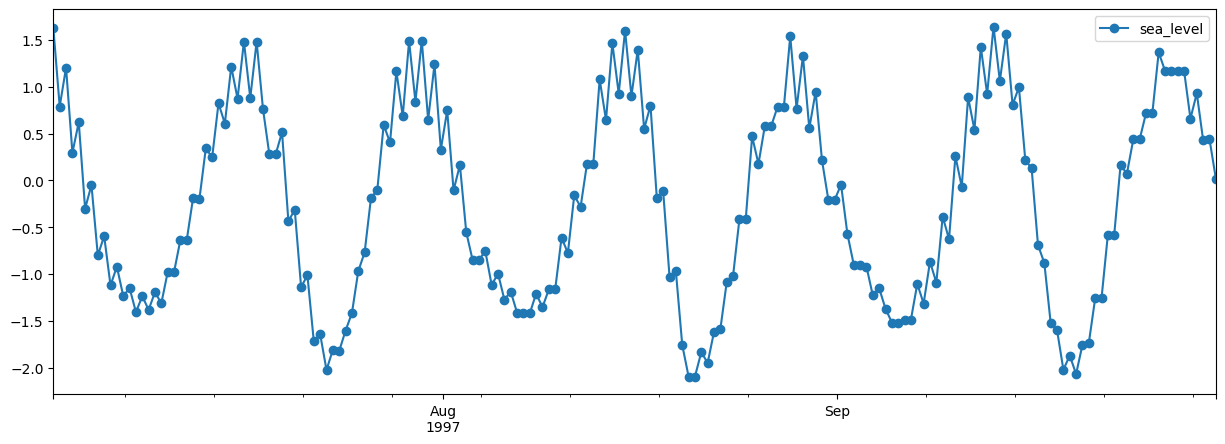

In [4]:
df.loc["1997-07":"1997-09"].plot(y="sea_level", style="o-", figsize=(15, 5))

# Predicting with autoregression

This section of the notebook will use statsmodels to generate a prediction for all dates after 2003-11-12. This portion of the notebook will generate predictions for an unseen month to make sure the value of `lags` makes sense.

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)  # statsmodels warns us a lot about mismatch between datetime/integer index

In [6]:
from statsmodels.tsa.ar_model import AutoReg

train = df.sea_level[:"2003-11-11"]
test = df.sea_level["2003-11-12":]

print("Train examples:", len(train))
print("Test examples:", len(test))

Train examples: 4844
Test examples: 100


Tides have a monthly cycle since the moon has a montly cycle. Let's specify `lags=2 * 30` so it gets measurements corresponding with the last month.

In [7]:
model1 = AutoReg(train, lags = 2*30)
model1_fit = model1.fit()

Let's visualize the predictions:

In [8]:
sea_level_pred = model1_fit.predict(start=len(train), end=len(train) + len(test) - 1)

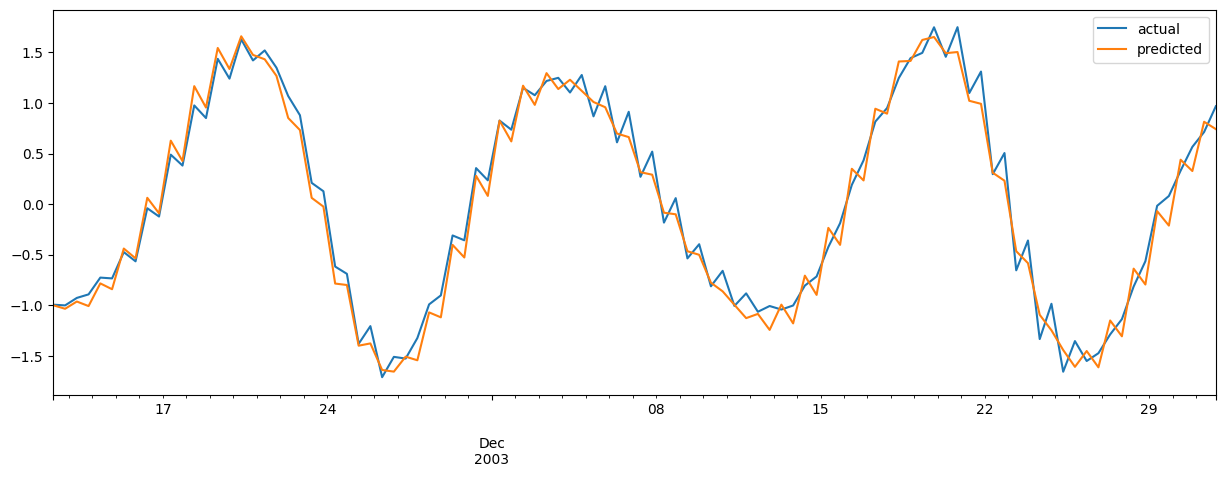

In [9]:
test_data = pd.DataFrame({"actual": test.values, "predicted": sea_level_pred.values}, index=test.index)
ax = test_data.plot(figsize=(15, 5))

This is far from perfect, but it's pretty good. Remember: this prediction is iterative. By the time we reach 2003-12-10, the predictions are entirely based on past predictions.

# Predicting with linear regression (Scikit-Learn)

Recall: **auto-regression is a linear regression that uses the last `lags` values of the time series as features**.

This section of the notebook will show how **auto-regression and linear regression are the same.**

## Create features

Some feature engineering needs to be performed. Auto-regression uses the last `lags` values of the time series as the features, and trains a linear model from those values.

Let's build those features manually:

In [10]:
def previous_and_current_values(x, lags=10):
    X = [np.flip(x[i - lags:i]) for i in range(lags, len(x))]
    y = [x.iloc[i] for i in range(lags, len(x))]
    return np.vstack(X), np.array(y)

Let's test it out to make sure `previous_and_current_values` is doing what it's supposed to be doing:

In [11]:
import numpy as np
x = pd.Series(np.arange(10))
print(x.values)

[0 1 2 3 4 5 6 7 8 9]


In [12]:
X, y = previous_and_current_values(x, lags=3)
print(X)
print(y)

[[2 1 0]
 [3 2 1]
 [4 3 2]
 [5 4 3]
 [6 5 4]
 [7 6 5]
 [8 7 6]]
[3 4 5 6 7 8 9]


In [13]:
maxlag = 2 * 30
X, y = previous_and_current_values(train, lags=maxlag)

## Generate prediction

Let's fit a linear model to these historical observations:

In [14]:
from sklearn.linear_model import LinearRegression

model2 = LinearRegression()
model2.fit(X, y)

LinearRegression()

Statsmodels and Scikit-Learn prediction for last day:

In [15]:
print("Using statsmodels:", model1_fit.predict(start=len(train) - 1, end=len(train) - 1).values)
print("Using scikit learn:", model2.predict(X[[-1]]))

Using statsmodels: [-0.91266924]
Using scikit learn: [-0.91266924]


In [16]:
# Ground truth for sea level for the last row of X:
y[-1]

-0.8963623046875

## Creating train/test data

Here, let's use `train_test_split` to get different examples.

This means that we will be testing our model on how will it predicts the *tomorrow's* sea level. Our model will not be evaluated on how well it predicts the sea level during a longer period of time.

In [17]:
from sklearn.model_selection import train_test_split

maxlag = 2 * 30
X, y = previous_and_current_values(df.sea_level, lags=maxlag)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Create model, fit and score.

In [18]:
model3 = LinearRegression()
model3.fit(X_train, y_train)

LinearRegression()

In [19]:
print(model3.score(X_train, y_train))
print(model3.score(X_test, y_test))

0.993745792800251
0.9924914233622273


(-2.223012275993824,
 2.1252875700592995,
 -2.1426890573449313,
 2.0897667572703735)

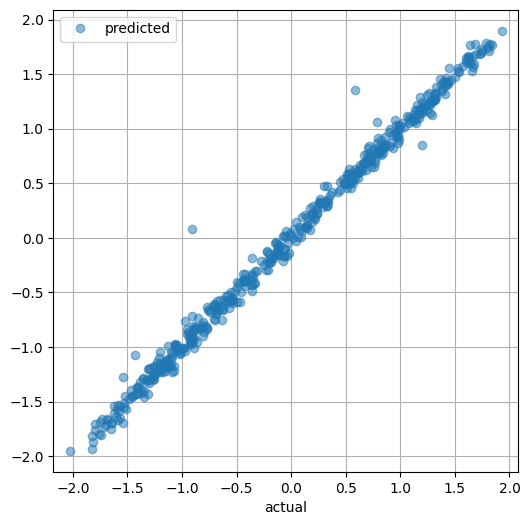

In [20]:
y_pred = model3.predict(X_test)
test_data = pd.DataFrame({"predicted": y_pred, "actual": y_test})
ax = test_data.plot(x="actual", y="predicted", style="o", figsize=(6,6), alpha=0.5, grid=True)
ax.axis('equal')